# General information

...

## M/M/n queues for FIFO

In [19]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Generator, List

### Functions for simulating a (Markovian) queue network

In [26]:
def interval_generator_markov(num_servers: int, arrival_rate: float) -> float:
    """Generate a random number from the distribution of Markovian interarrival times.

    Specifically, returns a number sampled from an exponential distribution with parameter
    'arrival rate' = λ.

    Args:
        num_servers: Number of servers in the system (n).
        arrival_rate: The arrival rate of the system (λ).

    Returns:
        Random number sampled from an exponential distribution with parameter arrival rate.
    """
    return random.expovariate(arrival_rate)

def service_time_generator_markov(service_rate: float) -> float:
    """Generate a random number from the distribution of Markovian service times.

    Specifically, returns a number sampled from an exponential distribution with parameter
    'service rate' = μ.

    Args:
        service_rate: The service rate or capacity of each server (μ).

    Returns:
        Random number sampled from an exponential distribution with parameter service rate.
    """
    return random.expovariate(service_rate)

def client_process(
    env: simpy.Environment,
    resources: simpy.Resource,
    service_rate: float,
    wait_records: List[float],
) -> Generator[simpy.events.Event, None, None]:
    """Simulates a single client's process through the queue system, including waiting and service times.

    Args:
        env: The SimPy environment managing simulation time.
        resources: The shared resource (e.g., servers) being accessed by the client.
        service_rate: The service rate or capacity of each server (μ).
        wait_records: A list to record the wait times of clients.

    Yields:
        Events representing the client's waiting and service times.
    """
    arrival_time = env.now
    with resources.request() as request:
        yield request  # Wait for resource availability
        wait_time = env.now - arrival_time
        wait_records.append(wait_time)  # Record the wait time
        yield env.timeout(service_time_generator_markov(service_rate))  # Simulate service time

def request_spawner(
    env: simpy.Environment,
    resources: simpy.Resource,
    num_servers: int,
    arrival_rate: float,
    service_rate: float,
    wait_records: List[float],
) -> Generator[simpy.events.Event, None, None]:
    """Continuously spawns client processes based on the interarrival time distribution.

    Args:
        env: The SimPy environment managing simulation time.
        resources: The shared resource (e.g., servers) being accessed by clients.
        num_servers: Number of servers in the system (n).
        arrival_rate: The arrival rate of the system (λ).
        service_rate: The service rate or capacity of each server (μ).
        wait_records: A list to record the wait times of clients.

    Yields:
        Events representing client arrivals and process creation.
    """
    while True:
        yield env.timeout(
            interval_generator_markov(num_servers, arrival_rate)
        )  # Interarrival time
        env.process(
            client_process(env, resources, service_rate, wait_records)
        )  # Create a new client process

def simulate_queue_network(
    num_servers: int, arrival_rate: float, service_rate: float, sim_time: float
) -> List[float]:
    """Simulates a queueing network with Markovian arrival and service processes.

    Args:
        num_servers: Number of servers in the system (n).
        arrival_rate: The arrival rate of the system (λ).
        service_rate: The service rate or capacity of each server (μ).
        sim_time: Total simulation time.

    Returns:
        A list of recorded wait times for all clients during the simulation.
    """
    # Calculate load factor (ρ) as λ / (n * μ)
    load_factor = arrival_rate / (num_servers * service_rate)
    if load_factor >= 1:
        raise ValueError("Load factor (ρ) must be less than 1 for a stable system.")

    env = simpy.Environment()
    resources = simpy.Resource(env, capacity=num_servers)
    wait_records: List[float] = []  # List to store wait times
    env.process(
        request_spawner(env, resources, num_servers, arrival_rate, service_rate, wait_records)
    )
    env.run(until=sim_time)  # Run the simulation
    return wait_records


### Helper functions for comparing queue networks with different load factor

In [27]:
def run_simulations(
    load_factors: List[float],
    runs_per_config: int,
    servers_count: int,
    service_rate: float,
    simulation_time: int,
) -> pd.DataFrame:
    """Run multiple simulations for a queueing network under various configurations.

    Args:
        load_factors: A list of load factors (ρ) to simulate.
        runs_per_config: The number of iterations to run for each load factor.
        servers_count: The number of servers in the queueing network.
        service_rate: The rate at which each server processes requests.
        simulation_time: The total time for each simulation run.

    Returns:
        A pandas DataFrame containing the simulation results with columns:
            - "Load Factor": The load factor (ρ) used in the simulation.
            - "Servers": The number of servers in the system.
            - "Customers": The number of customers considered.
            - "Iteration": The simulation iteration number.
            - "Mean Wait Time": The average waiting time for the given number of customers.
    """
    # Using a dictionary for results storage
    results_dict = {
        "Load Factor": [],
        "Servers": [],
        "Customers": [],
        "Iteration": [],
        "Mean Wait Time": [],
    }

    # Simulations with progress bars
    for load_factor in tqdm(load_factors, desc="Running simulations for different load factors"):
        arrival_rate = load_factor * servers_count * service_rate
        for iteration in tqdm(
            range(runs_per_config), leave=False, desc=f"Simulating for ρ={load_factor:.2f}"
        ):
            recorded_waits = simulate_queue_network(
                servers_count, arrival_rate, service_rate, simulation_time
            )
            customer_counts = np.concatenate(
                (
                    np.arange(100, 1000, 100),
                    np.arange(1000, 10000, 1000),
                    np.arange(10000, 100001, 10000),
                )
            )
            for count in customer_counts:
                if count <= len(recorded_waits):
                    average_wait = np.mean(recorded_waits[:count])
                    results_dict["Load Factor"].append(load_factor)
                    results_dict["Servers"].append(servers_count)
                    results_dict["Customers"].append(count)
                    results_dict["Iteration"].append(iteration)
                    results_dict["Mean Wait Time"].append(average_wait)

    # Convert the dictionary to a DataFrame
    results_df = pd.DataFrame(results_dict)
    return results_df


def plot_simulations(results_df: pd.DataFrame, load_factors: List[float]) -> None:
    """Plot the average waiting time as a function of the number of customers.

    Args:
        results_df: A pandas DataFrame containing simulation results, including:
            - "Load Factor": The load factor (ρ) used in the simulation.
            - "Customers": The number of customers considered.
            - "Mean Wait Time": The average waiting time for the given number of customers.
        load_factors: A list of load factors (ρ) to include in the plot.

    Returns:
        None. Displays a plot showing the relationship between the number of customers
        and the average waiting time for each load factor.
    """
    # Plotting the results
    plt.figure(figsize=(8, 6))
    for load_factor in load_factors:
        subset = results_df[results_df["Load Factor"] == load_factor]
        avg_waits = subset.groupby("Customers")["Mean Wait Time"].mean()
        plt.plot(avg_waits.index, avg_waits.values, label=f"ρ={load_factor}")

    plt.title("Average Waiting Time vs Number of Customers")
    plt.xlabel("Number of Customers")
    plt.ylabel("Average Waiting Time")
    plt.legend()
    plt.grid(True)
    plt.show()

Running simulations for different load factors: 100%|██████████| 4/4 [00:24<00:00,  6.13s/it]


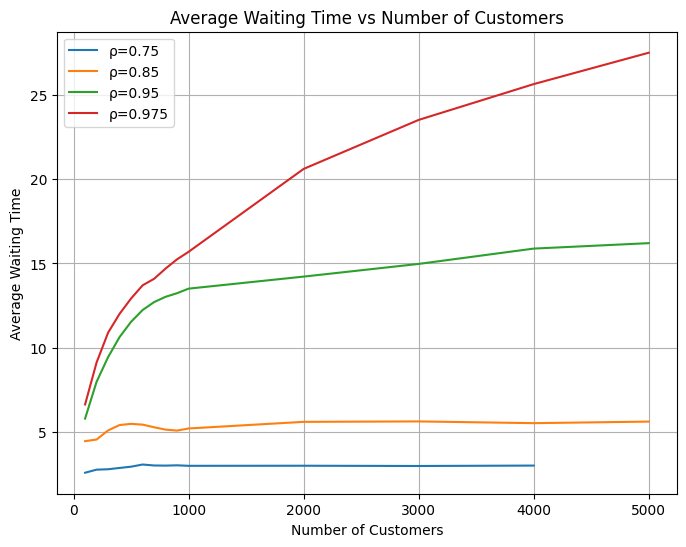

In [29]:
# Parameters
load_factors = [0.75, 0.85, 0.95, 0.975]
servers_count = 1
service_rate = 1.0
simulation_time = 6000
runs_per_config = 50

# Run simulations
results_df = run_simulations(load_factors, runs_per_config, servers_count, service_rate, simulation_time)

# Save the results to a CSV
results_df.to_csv("simulations_output2.csv", index=False)

# Plot the results
plot_simulations(results_df, load_factors)

### Exercise 2:

In [32]:
def run_single_simulation(
    servers_count: int, arrival_rate: float, service_rate: float, simulation_time: int, runs: int
) -> float:
    """Run a single configuration multiple times to compute the average waiting time.

    Args:
        servers_count: Number of servers in the system (n).
        arrival_rate: The arrival rate of the system (λ).
        service_rate: The service rate or capacity of each server (μ).
        simulation_time: Total simulation time.
        runs: Number of iterations to run for statistical significance.

    Returns:
        Tuple containing:
        - Mean waiting time across all runs.
        - Standard deviation of waiting times across all runs.
    """
    wait_times = []
    for _ in tqdm(range(runs), desc=f"Running for n={servers_count}, λ={arrival_rate:.3f}"):
        recorded_waits = simulate_queue_network(servers_count, arrival_rate, service_rate, simulation_time)
        wait_times.append(np.mean(recorded_waits))
    return np.mean(wait_times), np.std(wait_times)

# Configuration Parameters
load_factor = 0.975  # High system load (ρ)
service_rate = 1.0  # Service rate (μ)
simulation_time = 60000  # Simulation time
runs = 100  # Number of iterations for statistical significance
server_configs = [1, 2, 4]  # Number of servers (n=1, n=2, n=4)

# Run simulations for each server configuration
results = {}
for servers in server_configs:
    # Calculate arrival rate (λ = ρ * n * μ)
    arrival_rate = load_factor * servers * service_rate
    mean_wait, std_wait = run_single_simulation(servers, arrival_rate, service_rate, simulation_time, runs)
    results[servers] = {"Mean Wait Time": mean_wait, "Std Dev": std_wait}

# Insights on results
print("\nSimulation Results (ρ=0.975):")
for servers, metrics in results.items():
    print(
        f"n={servers}: "
        f"Mean Wait Time = {metrics['Mean Wait Time']:.4f}, "
        f"Std Dev = {metrics['Std Dev']:.4f}"
    )

# Insights
print("\nInsights:")
for servers in server_configs[1:]:
    reduction = (
        results[1]["Mean Wait Time"] - results[servers]["Mean Wait Time"]
    ) / results[1]["Mean Wait Time"] * 100
    print(
        f"Adding more servers (n={servers}): "
        f"Wait time reduced by {reduction:.2f}% compared to n=1."
    )


Running for n=4, λ=3.900: 100%|██████████| 100/100 [07:09<00:00,  4.30s/it]


Simulation Results (ρ=0.975):
n=1: Mean Wait Time = 38.2216, Std Dev = 11.7639
n=2: Mean Wait Time = 18.6087, Std Dev = 3.6723
n=4: Mean Wait Time = 9.0860, Std Dev = 1.3678

Insights:
Adding more servers (n=2): Wait time reduced by 51.31% compared to n=1.
Adding more servers (n=4): Wait time reduced by 76.23% compared to n=1.
